In [1]:
import os
ata_name = 'A9A'
trial_name ='A9A_t1'
log_path = os.path.join('logs',trial_name)
device ='cuda:0'

In [2]:
from data_loader import data_processing
data = data_processing(data_name,random_state=123)

In [2]:
import pandas as pd
import os
path = 'saved_data'
if os.path.exists(path) != True:
    os.mkdir(path)
saved_folder =  os.path.join(path, data_name)

if os.path.exists(saved_folder) != True:
    os.mkdir(saved_folder)

In [4]:
pd.to_pickle(data, os.path.join( saved_folder, data_name +'.all'))

In [3]:
data = pd.read_pickle(os.path.join( saved_folder, data_name +'.all'))

In [4]:
from net import DenseBlock
from nn_utils import entmax15,entmoid15,Lambda
from torch import nn

in_features = data['X_train'].shape[1]
print(in_features)

model = nn.Sequential(
    DenseBlock(in_features, 128, num_layers=8, tree_dim=3, depth=6, flatten = False,
                   choice_function= entmax15, bin_function= entmoid15),
    Lambda(lambda x: x[..., 0].mean(dim=-1)),  # average the first channels for every tree
).to(device)

123


In [5]:
from qhoptim.pyt import QHAdam
opt_params = { 'nus':(0.7, 1.0), 'betas':(0.95, 0.998) }

In [20]:
import torchbearer
import torch
from torchbearer import Trial
from torchbearer.callbacks.decorators import on_end_epoch
from torchbearer.callbacks.decorators import on_backward
from torchbearer.callbacks.decorators import on_end_validation
from torchbearer.callbacks.decorators import on_start_validation
from torch.utils.tensorboard import SummaryWriter
import os
from trial import eval_model
import torch.nn.functional as F


m = eval_model(model,loss_f=F.mse_loss,device=device,metrics=['loss','accuracy'], opt =QHAdam, trial_name=trial_name, opt_params=opt_params)

writer = SummaryWriter(os.path.join('writer',data_name),filename_suffix='.loss')
loss_his,val_loss = [],[]
settings = { 'stop_rounds':1000, 'best_step': 0,'c_val_loss': 1,}
@on_backward
def save_loss(state):
    tem = state[torchbearer.LOSS].data
    writer.add_scalar('Loss/train', tem, len(loss_his))
    loss_his.append(tem)
    if len(loss_his) > settings['stop_rounds']  + settings['best_step']:
        state[torchbearer.STOP_TRAINING] = True 
        print('No improvement, stop early!')

@on_end_validation
def best_mse(state):
    tem = state[torchbearer.LOSS].data
    writer.add_scalar('Loss/val',tem, len(val_loss))
    val_loss.append(tem)
    if settings['c_val_loss'] > tem.cpu():
        settings['c_val_loss'] = tem.cpu()
        settings['best_step'] = len(loss_his)
        m.best_step = len(loss_his)
        m.save_model('best')
m.call_backs = [save_loss, best_mse]
m.init_trial()

In [9]:
from data_set import MyDataset
params = {'batch_size': 512,
          'shuffle': True,}
          #'num_workers': 6}

test = MyDataset(data)
test.quantile_transform(noise=1e-3,random_state=1337)
test.normalised()
tr_loader = test.get_loader('train', params)
val_loader = test.get_loader('vaild',{'batch_size': 600})
t_loader = test.get_loader('test', params)
print('train data:', len(tr_loader.dataset))
print('val data:', len(val_loader.dataset))
print('test data:', len(t_loader.dataset))

train data: 26048
val data: 6513
test data: 16281


In [25]:
torch.save(tr_loader, os.path.join(saved_folder,'tr_'))
torch.save(val_loader, os.path.join(saved_folder,'val_'))
torch.save(t_loader,os.path.join(saved_folder,'t_'))

In [7]:
tr_loader = torch.load(os.path.join(saved_folder,'tr_'))
val_loader = torch.load(os.path.join(saved_folder,'val_'))
t_loader = torch.load(os.path.join(saved_folder,'t_'))

In [21]:
out = m.run(30,tr_loader=tr_loader,val_loader= val_loader, t_loader=t_loader,val_steps=None)
writer.close()

No improvement, stop early!



In [9]:
settings

{'stop_rounds': 1000, 'best_step': 153, 'c_val_loss': tensor(0.6530)}

In [12]:
import pickle
with open(os.path.join(log_path,'loss_his'), 'wb') as f:
    pickle.dump(loss_his, f)   
with open(os.path.join(log_path,'val_loss'), 'wb') as f:
    pickle.dump(val_loss, f)

In [20]:
import pickle
loss_his =  pickle.load(open(os.path.join(log_path,'loss_his'),"rb"))
val_loss =  pickle.load(open(os.path.join(log_path,'val_loss'),"rb"))

No handles with labels found to put in legend.


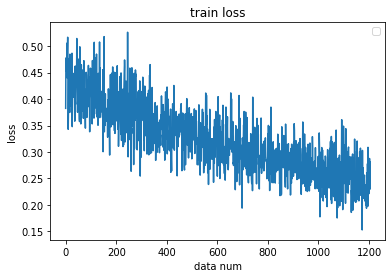

In [14]:
m.plot_loss(loss_his,'train loss','data num')

No handles with labels found to put in legend.


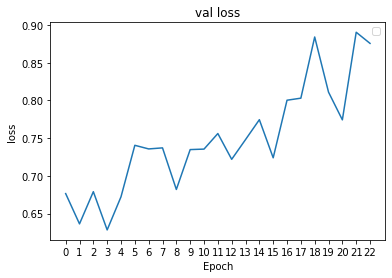

In [17]:
m.plot_loss(val_loss,'val loss','Epoch', x_all=True)

In [18]:
mu, std = data['y_train'].mean(), data['y_train'].std()
print(mu, ' ', std)

0.24178439803439802   0.4281643409971711


In [8]:
m.load_model('best')

In [19]:
m.best_step

204

In [15]:
m.trial.with_test_generator(t_loader)
t = m.trial.evaluate(data_key=torchbearer.TEST_DATA)

In [16]:
t

{'test_loss': 0.5931424498558044, 'test_mse': 0.5928422212600708}

In [19]:
t['test_mse'] * std ** 2

0.1086826240799926